**BƯỚC 1: TIỀN XỬ LÝ DỮ LIỆU**

**Import các thư viện cần thiết**

In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=1028f60198aaa207bc809efd1e5c8b62ed061c4f678921ccffa6e32faee68c66
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [2]:
import re
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
#NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
#Trích xuất đặc trưng
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt
import seaborn as sns
#Huấn luyện mô hình
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report
print('Finish importing libraries')

Finish importing libraries


**Trực quan hóa dữ liệu (EDA)**

In [3]:
# Trên Kaggle, dataset nằm trong /kaggle/input/
RAW_CSV = Path("/kaggle/input/mbti-type/mbti_1.csv") 
OUT_ROOT = Path("/kaggle/working")  # output lưu ở đây để tải về
REPORTS = OUT_ROOT / "reports"
RANDOM_SEED = 42
#Tạo thư mục
for d in [OUT_ROOT, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)
# --- Load ---
if not RAW_CSV.exists():
    raise FileNotFoundError(f"Dataset not found at {RAW_CSV}.")
df = pd.read_csv(RAW_CSV)
print("Loaded:", RAW_CSV, "shape:", df.shape)
print("Columns:", df.columns.tolist())
print()

Loaded: /kaggle/input/mbti-type/mbti_1.csv shape: (8675, 2)
Columns: ['type', 'posts']



In [4]:
# ==========================================
# 1. DATA QUALITY CHECKS
# ==========================================
print("\n=== DATA QUALITY CHECKS ===")

# Kiểm tra có thiếu dữ liệu hay không?
missing_counts = df.isna().sum()
if missing_counts.any():
    print("Missing values per column:")
    print(missing_counts[missing_counts > 0])
else:
    print("No missing values.")

# Kiểm tra trùng nội dung và trùng "post content" nhưng khác type MBTI
dup_full = df.duplicated().sum()
print(f"Duplicate full rows: {dup_full}")
if 'posts' in df.columns:
    dup_posts = df['posts'].duplicated().sum()
    print(f"Duplicate 'posts' content: {dup_posts}")

#Kiểm tra ngôn ngữ (optional)
try:
    DetectorFactory.seed = RANDOM_SEED

    sample = df['posts'].dropna().sample(min(50, len(df)), random_state=RANDOM_SEED)
    non_english = []
    for t in sample:
        try:
            if detect(str(t)) != "en":  # dataset MBTI gốc là tiếng Anh
                non_english.append(t)
        except:
            non_english.append(t)
    if non_english:
        print(f"Found {len(non_english)} non-English samples in a sample of 50.")
    else:
        print("All sample posts are detected as English.")
except ImportError:
    print("langdetect not installed, skipping language check.")

print("=== DONE QUALITY CHECKS ===\n")


=== DATA QUALITY CHECKS ===
No missing values.
Duplicate full rows: 0
Duplicate 'posts' content: 0
All sample posts are detected as English.
=== DONE QUALITY CHECKS ===



In [5]:
# ==========================================
# 2. FEATURE ENGINEERING (text-based stats)
# ==========================================
if 'text' not in df.columns:
    if 'posts' in df.columns:
        df['text'] = df['posts'].astype(str)
    else:
        raise ValueError("Input CSV must include 'posts' or 'text' column")

# --- Post count ---
def count_posts_field(s):
    s = str(s)
    return s.count('|||') + 1 if s.strip() != '' else 0

df['post_count'] = df['posts'].apply(count_posts_field)

# --- Length & punctuation / URL / emoji counts ---
df['text_len_chars'] = df['text'].astype(str).apply(len)
df['text_len_words'] = df['text'].astype(str).apply(lambda s: len(str(s).split()))

url_re = re.compile(r'http\S+|www\.\S+')
df['n_urls'] = df['text'].astype(str).apply(lambda s: len(url_re.findall(s)))
df['n_q'] = df['text'].astype(str).apply(lambda s: s.count('?'))
df['n_excl'] = df['text'].astype(str).apply(lambda s: s.count('!'))
df['n_nonascii_chars'] = df['text'].astype(str).apply(lambda s: sum(1 for ch in s if ord(ch) > 127))
df['frac_ascii_chars'] = df['text'].astype(str).apply(lambda s: sum(1 for ch in s if ord(ch) < 128) / max(1, len(s)))
print("DONE FEATURE EGINEERING")


DONE FEATURE EGINEERING


In [6]:
# ==========================================
# 3. MBTI axes extraction (IE, SN, TF, JP)
# ==========================================
if 'type' not in df.columns:
    raise ValueError("Input CSV must contain 'type' column with MBTI labels (e.g. INTP)")

def axes_from_type(t):
    s = str(t).strip().upper()
    s = (s + "XXXX")[:4]
    return pd.Series({
        'IE': 1 if s[0] == 'I' else 0,
        'SN': 1 if s[1] == 'N' else 0,
        'TF': 1 if s[2] == 'T' else 0,
        'JP': 1 if s[3] == 'J' else 0
    })

axes_df = df['type'].apply(axes_from_type)
df = pd.concat([df, axes_df], axis=1)


In [7]:
# ==========================================
# 4. Distributions & summary stats
# ==========================================
type_counts = df['type'].value_counts().sort_values(ascending=False)
axis_counts = {
    'I': int(df['IE'].sum()),
    'E': int((df['IE'] == 0).sum()),
    'N': int(df['SN'].sum()),
    'S': int((df['SN'] == 0).sum()),
    'T': int(df['TF'].sum()),
    'F': int((df['TF'] == 0).sum()),
    'J': int(df['JP'].sum()),
    'P': int((df['JP'] == 0).sum())
}

summary = {
    "n_samples": int(len(df)),
    "unique_mbti_types": int(df['type'].nunique()),
    "top_mbti_counts": type_counts.head(12).to_dict(),
    "axis_counts": axis_counts,
    "text_len_chars_mean": float(df['text_len_chars'].mean()),
    "text_len_chars_median": float(df['text_len_chars'].median()),
    "text_len_words_mean": float(df['text_len_words'].mean()),
    "text_len_words_median": float(df['text_len_words'].median()),
    "avg_urls_per_user": float(df['n_urls'].mean()),
    "avg_questions_per_user": float(df['n_q'].mean()),
    "avg_exclaims_per_user": float(df['n_excl'].mean()),
    "avg_nonascii_per_user": float(df['n_nonascii_chars'].mean()),
    "avg_frac_ascii": float(df['frac_ascii_chars'].mean())
}
print(json.dumps(summary, indent=2))

# --- Save EDA table summary CSV ---
eda_table = df[['type','post_count','text_len_chars','text_len_words','n_urls','n_q','n_excl','n_nonascii_chars','frac_ascii_chars']].copy()
eda_table.to_csv(REPORTS / "eda_table_summary.csv", index=False)


{
  "n_samples": 8675,
  "unique_mbti_types": 16,
  "top_mbti_counts": {
    "INFP": 1832,
    "INFJ": 1470,
    "INTP": 1304,
    "INTJ": 1091,
    "ENTP": 685,
    "ENFP": 675,
    "ISTP": 337,
    "ISFP": 271,
    "ENTJ": 231,
    "ISTJ": 205,
    "ENFJ": 190,
    "ISFJ": 166
  },
  "axis_counts": {
    "I": 6676,
    "E": 1999,
    "N": 7478,
    "S": 1197,
    "T": 3981,
    "F": 4694,
    "J": 3434,
    "P": 5241
  },
  "text_len_chars_mean": 7234.98962536023,
  "text_len_chars_median": 7515.0,
  "text_len_words_mean": 1226.2414985590779,
  "text_len_words_median": 1278.0,
  "avg_urls_per_user": 2.875734870317003,
  "avg_questions_per_user": 10.730951008645533,
  "avg_exclaims_per_user": 8.454293948126802,
  "avg_nonascii_per_user": 1.0863400576368876,
  "avg_frac_ascii": 0.9998354393479015
}


In [8]:
# ==========================================
# 5. Plots
# ==========================================
plt.figure(figsize=(12,5))
type_counts.plot(kind='bar')
plt.title("MBTI 16-class distribution")
plt.xlabel("MBTI type")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(REPORTS / "mbti_type_dist.png")
plt.close()

plt.figure(figsize=(7,3))
keys = ['I','E','N','S','T','F','J','P']
vals = [axis_counts[k] for k in keys]
plt.bar(keys, vals)
plt.title("MBTI axis distribution (counts)")
plt.tight_layout()
plt.savefig(REPORTS / "mbti_axis_dist.png")
plt.close()

plt.figure(figsize=(6,3))
plt.hist(df['text_len_words'].clip(upper=400), bins=50)
plt.title("Distribution of total words per user (clipped at 400)")
plt.xlabel("words")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(REPORTS / "text_length_hist.png")
plt.close()

In [9]:
# ==========================================
# 6. Mask sample text and save
# ==========================================
def mask_pii(text, char_limit=800):
    if pd.isnull(text):
        return ""
    t = re.sub(r'http\S+|www\.\S+|\.com\S+|\S+@\S+', '<PII>', str(text))
    return t[:char_limit].replace('\n', ' ')

sample_masked = df.sample(4, random_state=RANDOM_SEED)[['type','text']].copy()
sample_masked['masked'] = sample_masked['text'].apply(mask_pii)
sample_masked.to_csv(REPORTS / "sample_masked_examples.csv", index=False)

print("\nMasked sample posts (first 2):")
for i, row in sample_masked.head(2).iterrows():
    print(f"[{row['type']}] {row['masked'][:400]}\n")

print("EDA CSV and plots saved to:", REPORTS)
print("Done.")


Masked sample posts (first 2):
[INTP] 'This. When I lie it's to avoid an unreasonable response for something I did that was completely justifiable to me but if I was to try to justify to someone else they'd be too hung up on what I did. I...|||Your IQ (SD15): 128|||I typically have very difficult times maintaining friends I've come to realize. I've had people I talk to for years and I still don't want to talk to them... I DID, but the

[INTJ] 'I said zero flexibility and little time for dating. Going around sifting through dates to find one that clicks isn't going to be as viable.  That has nothing to do with maintaining a relationship I...|||How you've come to the conclusion I have nothing to offer  merely because I am busy is beyond me.       No not really. Again, more made up stuff.|||okay, this isn't cool.  you're specifically look

EDA CSV and plots saved to: /kaggle/working/reports
Done.


**Bắt đầu tiền xử lý dữ liệu**

In [10]:
#Xoá URL, emoji, ký tự đặc biệt, lowercase
def basic_clean(text):
    text = str(text).lower()   # ép text về dạng string và chuyển thành chữ thường
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)   # xoá link (URL)
    text = re.sub(r"[^a-z\s]", " ", text)                  # giữ lại chỉ chữ cái (a-z) và khoảng trắng
    return text
df["clean_step1"] = df["text"].apply(basic_clean)          # áp dụng hàm cho toàn bộ cột text
df[["text", "clean_step1"]].sample(5, random_state=42)                      # hiển thị random để trực quan

,text,clean_step1
2802,'This. When I lie it's to avoid an unreasonabl...,this when i lie it s to avoid an unreasonabl...
2166,'I said zero flexibility and little time for d...,i said zero flexibility and little time for d...
1919,'This has to be written with bias or something...,this has to be written with bias or something...
360,'HAuhuHAuh You might be right Muhicz. I'm just...,hauhuhauh you might be right muhicz i m just...
1115,'Her parents are kind of the go to college = g...,her parents are kind of the go to college g...


In [11]:
#Tokenize
nltk.download("punkt")# Tải gói cần thiết (chỉ cần chạy 1 lần)
df["clean_step2"] = df["clean_step1"].apply(word_tokenize)
df[["clean_step1", "clean_step2"]].sample(5, random_state=42)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,clean_step1,clean_step2
2802,this when i lie it s to avoid an unreasonabl...,"[this, when, i, lie, it, s, to, avoid, an, unr..."
2166,i said zero flexibility and little time for d...,"[i, said, zero, flexibility, and, little, time..."
1919,this has to be written with bias or something...,"[this, has, to, be, written, with, bias, or, s..."
360,hauhuhauh you might be right muhicz i m just...,"[hauhuhauh, you, might, be, right, muhicz, i, ..."
1115,her parents are kind of the go to college g...,"[her, parents, are, kind, of, the, go, to, col..."


In [12]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
df["clean_step3"] = df["clean_step2"].apply(lambda tokens: [w for w in tokens if w not in stop_words])
# Hiển thị 5 mẫu
df[["clean_step2", "clean_step3"]].sample(5, random_state=42)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_step2,clean_step3
2802,"[this, when, i, lie, it, s, to, avoid, an, unr...","[lie, avoid, unreasonable, response, something..."
2166,"[i, said, zero, flexibility, and, little, time...","[said, zero, flexibility, little, time, dating..."
1919,"[this, has, to, be, written, with, bias, or, s...","[written, bias, something, sure, could, even, ..."
360,"[hauhuhauh, you, might, be, right, muhicz, i, ...","[hauhuhauh, might, right, muhicz, wondering, s..."
1115,"[her, parents, are, kind, of, the, go, to, col...","[parents, kind, go, college, good, job, people..."


In [13]:
nltk.download("wordnet")
nltk.download("omw-1.4")
lemmatizer = WordNetLemmatizer()
df["clean_step4"] = df["clean_step3"].apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])
# Ghép lại thành chuỗi để dễ đưa vào TF-IDF
df["clean_step4"] = df["clean_step4"].apply(lambda tokens: " ".join(tokens))
# Hiển thị 5 mẫu
df[["clean_step3", "clean_step4"]].sample(5, random_state=42)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


,clean_step3,clean_step4
2802,"[lie, avoid, unreasonable, response, something...",lie avoid unreasonable response something comp...
2166,"[said, zero, flexibility, little, time, dating...",said zero flexibility little time dating going...
1919,"[written, bias, something, sure, could, even, ...",written bias something sure could even say tru...
360,"[hauhuhauh, might, right, muhicz, wondering, s...",hauhuhauh might right muhicz wondering step co...
1115,"[parents, kind, go, college, good, job, people...",parent kind go college good job people want st...


In [14]:
#Gán nhãn MBTI thành 4 trục nhị phân

def mbti_to_binary(mbti_type):
    """
    Chuyển MBTI string (ví dụ: INFJ) thành 4 binary labels.
    I/E, N/S, T/F, J/P -> 0/1
    """
    return pd.Series({
        "IE": 1 if mbti_type[0] == "I" else 0,   # I=1, E=0
        "SN": 1 if mbti_type[1] == "N" else 0,   # N=1, S=0
        "TF": 1 if mbti_type[2] == "T" else 0,   # T=1, F=0
        "JP": 1 if mbti_type[3] == "J" else 0    # J=1, P=0
    })

# Xóa nếu đã có các cột để tránh trùng lặp
for col in ["IE", "SN", "TF", "JP"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Áp dụng gán nhãn
y = df["type"].apply(mbti_to_binary)
df = pd.concat([df, y], axis=1)

# Hiển thị thử một vài dòng
df[["type", "IE", "SN", "TF", "JP", "clean_step4"]].sample(5, random_state=42)


,type,IE,SN,TF,JP,clean_step4
2802,INTP,1,1,1,0,lie avoid unreasonable response something comp...
2166,INTJ,1,1,1,1,said zero flexibility little time dating going...
1919,INTP,1,1,1,0,written bias something sure could even say tru...
360,ENFP,0,1,0,0,hauhuhauh might right muhicz wondering step co...
1115,ENTJ,0,1,1,1,parent kind go college good job people want st...


**Chia dữ liệu thành 3 tập train, valid, test**

In [15]:
# Chia X (text) và y (labels)
X = df["clean_step4"].astype(str)   # đảm bảo dạng string
y = df[["IE", "SN", "TF", "JP"]]

# Chia Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y["IE"]
)

# Chia Temp thành Valid (15%) và Test (15%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp["IE"]
)

print("Train size:", X_train.shape[0])
print("Valid size:", X_valid.shape[0])
print("Test size:",  X_test.shape[0])

# Gộp text + labels lại để lưu CSV
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
valid_df = pd.concat([X_valid.reset_index(drop=True), y_valid.reset_index(drop=True)], axis=1)
test_df  = pd.concat([X_test.reset_index(drop=True),  y_test.reset_index(drop=True)],  axis=1)

train_df.rename(columns={"clean_step4": "text"}, inplace=True)
valid_df.rename(columns={"clean_step4": "text"}, inplace=True)
test_df.rename(columns={"clean_step4": "text"}, inplace=True)

# Tạo thư mục output
OUTPUT_DIR = "/kaggle/working/reports/split_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Xuất CSV
train_df.to_csv(os.path.join(OUTPUT_DIR, "train.csv"), index=False)
valid_df.to_csv(os.path.join(OUTPUT_DIR, "valid.csv"), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, "test.csv"), index=False)

print("Saved train/valid/test splits to:", OUTPUT_DIR)

# Hiển thị một vài sample để trực quan
train_df.sample(3, random_state=42)


Train size: 6072
Valid size: 1301
Test size: 1302
Saved train/valid/test splits to: /kaggle/working/reports/split_data


,text,IE,SN,TF,JP
5213,google intp came sorry hate picture post cuz g...,1,1,1,0
5322,thanks guy admittedly trained persistent abuse...,0,1,1,1
1657,also labelling hate group hate speech e people...,1,1,1,0


**BƯỚC 2: TRÍCH XUẤT ĐẶC TRƯNG**

In [16]:
# TF-IDF cho word-level (1-2 gram)
tfidf_word = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,2),
    max_features=20000,
    stop_words="english"
)

# TF-IDF cho char-level (3-5 gram)
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    max_features=30000
)

# Fit + Transform
X_train_word = tfidf_word.fit_transform(X_train)
X_valid_word = tfidf_word.transform(X_valid)
X_test_word  = tfidf_word.transform(X_test)

X_train_char = tfidf_char.fit_transform(X_train)
X_valid_char = tfidf_char.transform(X_valid)
X_test_char  = tfidf_char.transform(X_test)

# Kết hợp word + char (tuỳ chọn baseline)
from scipy.sparse import hstack
X_train_tfidf = hstack([X_train_word, X_train_char])
X_valid_tfidf = hstack([X_valid_word, X_valid_char])
X_test_tfidf  = hstack([X_test_word,  X_test_char])

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Valid:", X_valid_tfidf.shape)
print("Test:",  X_test_tfidf.shape)

# Trực quan hóa: top feature TF-IDF
feature_names = tfidf_word.get_feature_names_out()
import numpy as np

# Lấy 10 feature có IDF thấp nhất (xuất hiện phổ biến nhất)
idf_scores = tfidf_word.idf_
top_common = sorted(zip(feature_names, idf_scores), key=lambda x: x[1])[:10]

pd.DataFrame(top_common, columns=["Feature", "IDF"]).head(10)


TF-IDF shapes:
Train: (6072, 50000)
Valid: (1301, 50000)
Test: (1302, 50000)


,Feature,IDF
0,like,1.013261
1,think,1.038266
2,people,1.043756
3,know,1.053784
4,time,1.057439
5,thing,1.076099
6,really,1.096562
7,make,1.117824
8,way,1.147913
9,say,1.156156


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


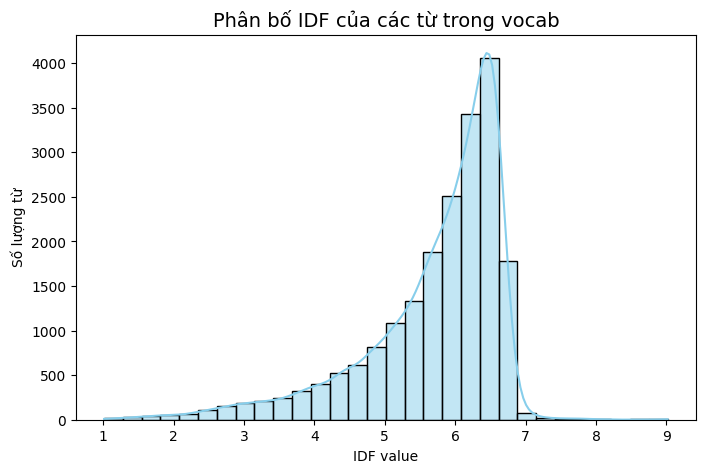


🔹 Top 10 từ phổ biến nhất (IDF thấp):


,Feature,IDF
9137,like,1.013261
17112,think,1.038266
12066,people,1.043756
8552,know,1.053784
17642,time,1.057439
16912,thing,1.076099
13702,really,1.096562
10179,make,1.117824
19155,way,1.147913
14692,say,1.156156



🔹 Top 10 từ hiếm nhất (IDF cao):


,Feature,IDF
3775,dreamingangel,9.018461
10817,miranda infj,9.018461
19761,xoxo miranda,9.018461
2077,chung daydream,9.018461
11117,naomi chung,9.018461
14009,regard hi,9.018461
3068,daydream art,8.612996
2076,chung,8.612996
7107,hope interesting,8.612996
12062,penguin penguin,8.102170


In [17]:
# Lấy toàn bộ IDF values
idf_values = tfidf_word.idf_
features = tfidf_word.get_feature_names_out()

# Vẽ histogram
plt.figure(figsize=(8,5))
sns.histplot(idf_values, bins=30, kde=True, color="skyblue")
plt.title("Phân bố IDF của các từ trong vocab", fontsize=14)
plt.xlabel("IDF value")
plt.ylabel("Số lượng từ")
plt.show()

# In ra top 10 từ phổ biến nhất (IDF thấp) và hiếm nhất (IDF cao)
idf_df = pd.DataFrame({"Feature": features, "IDF": idf_values})
print("\n🔹 Top 10 từ phổ biến nhất (IDF thấp):")
display(idf_df.sort_values("IDF", ascending=True).head(10))

print("\n🔹 Top 10 từ hiếm nhất (IDF cao):")
display(idf_df.sort_values("IDF", ascending=False).head(10))


**BƯỚC 3: HUẤN LUYỆN VÀ SO SÁNH CÁC MÔ HÌNH**

In [18]:

# Logistic Regression
log_reg = LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")
log_reg_clf = MultiOutputClassifier(log_reg)
log_reg_clf.fit(X_train_word, y_train)
y_pred_log = log_reg_clf.predict(X_valid_word)

print("=== Logistic Regression (Validation) ===")
print(classification_report(y_valid, y_pred_log))

# Train Linear SVM
svm_clf = MultiOutputClassifier(
    LinearSVC(class_weight="balanced", max_iter=2000, random_state=42)
)
svm_clf.fit(X_train_word, y_train)
# Predict trên validation
y_pred_svm = svm_clf.predict(X_valid_word)
print("\n=== Linear SVM (Validation) ===")
print(classification_report(y_valid, y_pred_svm))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1, random_state=42)
rf_clf = MultiOutputClassifier(rf)
rf_clf.fit(X_train_word, y_train)
y_pred_rf = rf_clf.predict(X_valid_word)

print("\n=== Random Forest (Validation) ===")
print(classification_report(y_valid, y_pred_rf))

=== Logistic Regression (Validation) ===
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1001
           1       0.96      0.93      0.94      1131
           2       0.83      0.86      0.85       599
           3       0.79      0.75      0.77       543

   micro avg       0.89      0.88      0.89      3274
   macro avg       0.87      0.86      0.87      3274
weighted avg       0.89      0.88      0.89      3274
 samples avg       0.89      0.88      0.86      3274



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Linear SVM (Validation) ===
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1001
           1       0.95      0.96      0.95      1131
           2       0.83      0.84      0.84       599
           3       0.79      0.72      0.75       543

   micro avg       0.88      0.88      0.88      3274
   macro avg       0.86      0.86      0.86      3274
weighted avg       0.88      0.88      0.88      3274
 samples avg       0.88      0.89      0.87      3274



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Random Forest (Validation) ===
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1001
           1       0.87      1.00      0.93      1131
           2       0.85      0.71      0.77       599
           3       0.90      0.31      0.47       543

   micro avg       0.83      0.83      0.83      3274
   macro avg       0.85      0.76      0.76      3274
weighted avg       0.84      0.83      0.81      3274
 samples avg       0.83      0.85      0.82      3274



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
axes = ["I/E", "S/N", "T/F", "J/P"]

def evaluate_model(name, clf, X_test, y_test):
    y_pred = clf.predict(X_test)

    # Accuracy / F1 cho từng trục
    axis_metrics = {}
    for i, axis in enumerate(axes):
        acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
        f1  = f1_score(y_test.iloc[:, i], y_pred[:, i], average="macro")
        axis_metrics[axis] = f"{acc:.2f} / {f1:.2f}"

    # Tổng hợp
    return {
        "Model": name,
        **axis_metrics,
        "Per-label Acc": np.mean([accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]),
        "Macro-F1": f1_score(y_test, y_pred, average="macro")
    }

# --- Chạy cho cả 3 mô hình ---
results = []
results.append(evaluate_model("Logistic Regression", log_reg_clf, X_test_word, y_test))
results.append(evaluate_model("Linear SVM", svm_clf, X_test_word, y_test))
results.append(evaluate_model("Random Forest", rf_clf, X_test_word, y_test))

# --- Đưa vào DataFrame ---
df_results = pd.DataFrame(results)

# Hiển thị
print("\n=== Bảng tổng hợp kết quả trên tập Test ===")
display(df_results)



=== Bảng tổng hợp kết quả trên tập Test ===


,Model,I/E,S/N,T/F,J/P,Per-label Acc,Macro-F1
0,Logistic Regression,0.85 / 0.80,0.91 / 0.82,0.86 / 0.86,0.80 / 0.79,0.856759,0.864691
1,Linear SVM,0.85 / 0.78,0.91 / 0.78,0.85 / 0.85,0.78 / 0.77,0.844662,0.851693
2,Random Forest,0.77 / 0.46,0.87 / 0.47,0.80 / 0.80,0.69 / 0.61,0.784562,0.751422


In [20]:
# --- Chuyển nhãn nhị phân (IE,SN,TF,JP) thành MBTI string ---
def binary_to_mbti(y_bin):
    mapping = [
        ("E","I"),  # IE
        ("S","N"),  # SN
        ("F","T"),  # TF
        ("P","J")   # JP
    ]
    result = []
    for row in y_bin:
        mbti = "".join([ mapping[i][val] for i,val in enumerate(row) ])
        result.append(mbti)
    return np.array(result)

# --- Hàm evaluate full MBTI ---
def evaluate_full_mbti(name, clf, X_test, y_test):
    # predict binary
    y_pred = clf.predict(X_test)

    # convert to MBTI type
    y_true_mbti = binary_to_mbti(y_test.values)
    y_pred_mbti = binary_to_mbti(y_pred)

    # metrics
    acc = accuracy_score(y_true_mbti, y_pred_mbti)
    macro_f1 = f1_score(y_true_mbti, y_pred_mbti, average="macro")

    return {"Model": name, "Exact Accuracy": acc, "Macro-F1": macro_f1}

# --- Chạy cho 3 mô hình ---
overall_results = []
overall_results.append(evaluate_full_mbti("Logistic Regression", log_reg_clf, X_test_word, y_test))
overall_results.append(evaluate_full_mbti("Linear SVM", svm_clf, X_test_word, y_test))
overall_results.append(evaluate_full_mbti("Random Forest", rf_clf, X_test_word, y_test))

df_overall = pd.DataFrame(overall_results)
print("\n=== Hiệu năng tổng thể (Full MBTI 16 lớp) ===")
print(df_overall)



=== Hiệu năng tổng thể (Full MBTI 16 lớp) ===
                 Model  Exact Accuracy  Macro-F1
0  Logistic Regression        0.594470  0.414886
1           Linear SVM        0.556836  0.389641
2        Random Forest        0.403994  0.119294


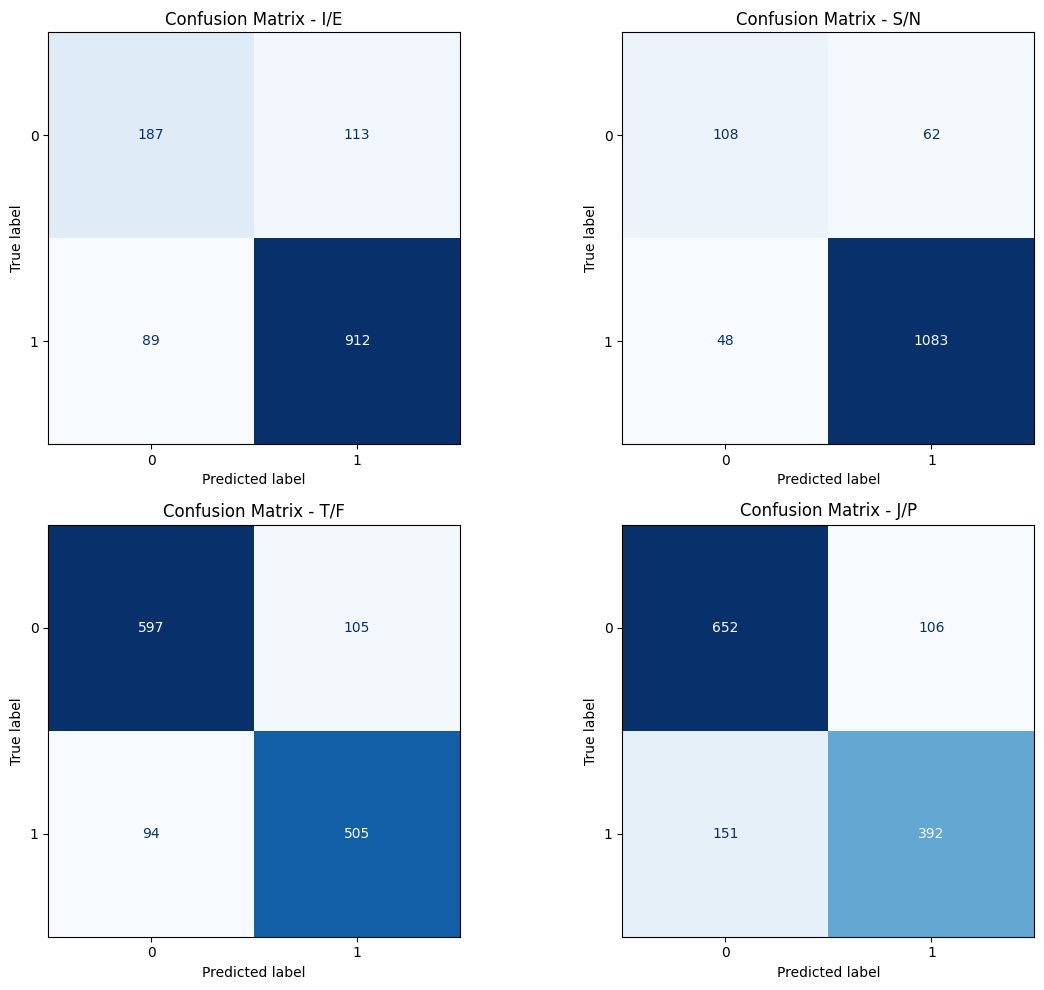

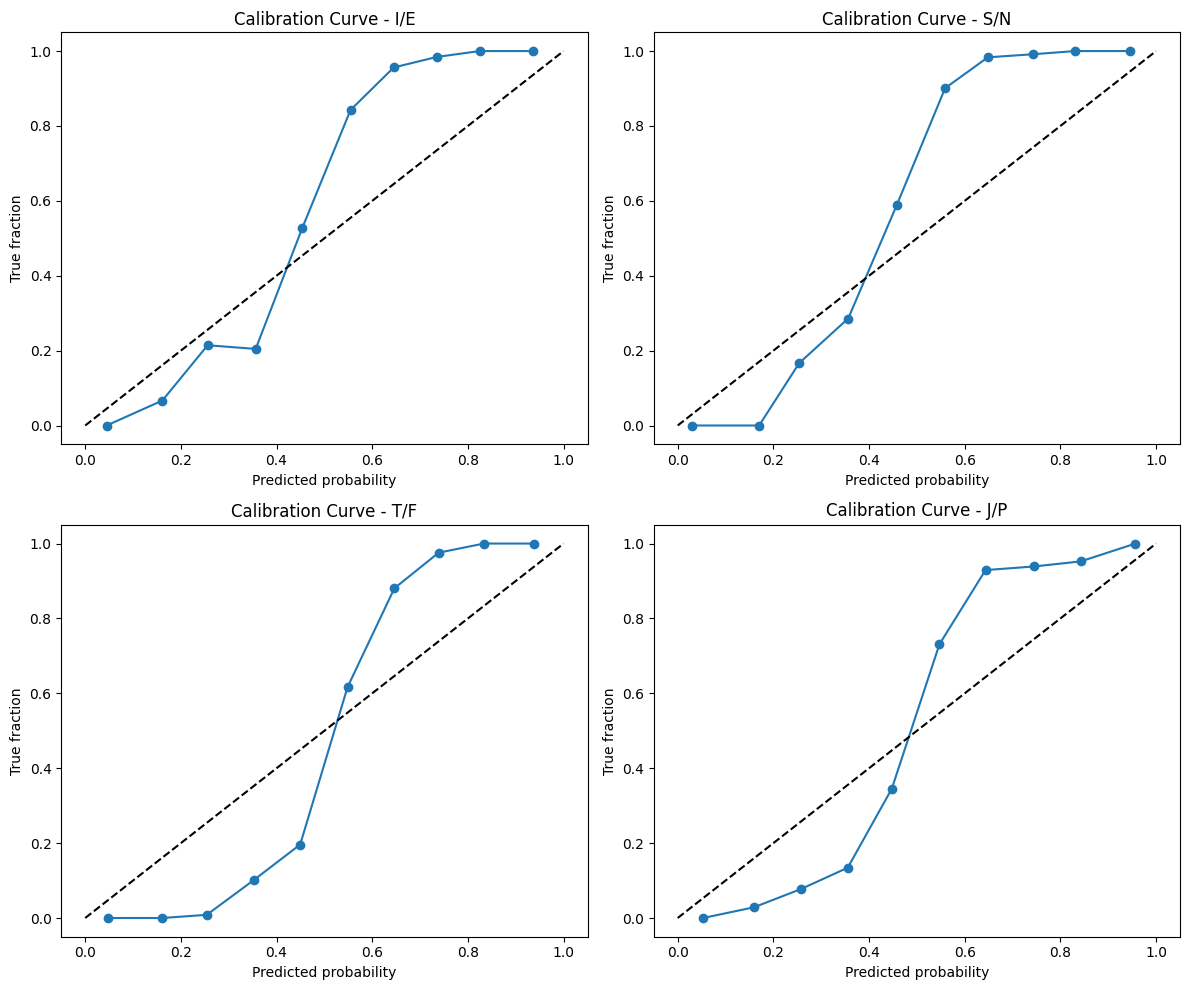

In [22]:
# ==============================
# Confusion Matrix + Calibration
# ==============================
# Vẽ Confusion Matrix cho từng trục
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
labels = ["I/E", "S/N", "T/F", "J/P"]

for i, col in enumerate(y_valid.columns):
    cm = confusion_matrix(y_valid[col], y_pred_svm[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"Confusion Matrix - {labels[i]}")

plt.tight_layout()
plt.show()

# ==============================
# Calibration curve (phân bố xác suất dự đoán)
# ==============================
# ⚠️ LinearSVC không có `predict_proba`, chỉ có `decision_function`
# => ta chuẩn hóa decision_function để xấp xỉ xác suất
import numpy as np
from sklearn.preprocessing import MinMaxScaler

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, col in enumerate(y_valid.columns):
    # Lấy decision_function
    scores = svm_clf.estimators_[i].decision_function(X_valid_word)
    
    # Chuyển về [0,1] bằng MinMaxScaler
    probs = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
    
    # Calibration curve
    frac_pos, mean_pred = calibration_curve(y_valid[col], probs, n_bins=10)
    
    axes[i].plot(mean_pred, frac_pos, marker="o", label="SVM")
    axes[i].plot([0, 1], [0, 1], "k--")  # đường chuẩn
    axes[i].set_title(f"Calibration Curve - {labels[i]}")
    axes[i].set_xlabel("Predicted probability")
    axes[i].set_ylabel("True fraction")

plt.tight_layout()
plt.show()


Macro-F1 với 50 post: 0.7944
Macro-F1 với 10 post: 0.7183
Macro-F1 với 1 post: 0.5820


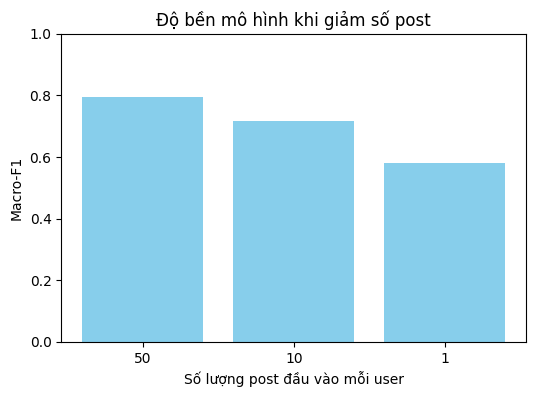

In [30]:
# Hàm tính Macro-F1 khi giới hạn số post
def evaluate_with_limited_posts(X_raw, y, limit_posts, vectorizer, model, X_full_vec=None):
    """
    X_raw: dữ liệu gốc (Series, mỗi user là list các post hoặc text gộp)
    y: nhãn
    limit_posts: số post giới hạn (hoặc 'full')
    vectorizer: TF-IDF
    model: classifier đã train
    X_full_vec: dữ liệu đã vectorize sẵn (dùng cho 'full')
    """
    if limit_posts == "full":
        # Dùng vector đã chuẩn bị sẵn cho test set
        X_vec = X_full_vec
    else:
        X_limited = []
        for posts in X_raw:
            if isinstance(posts, list):
                subset = posts[:limit_posts]
                joined = " ".join(subset)
            else:
                # Nếu đã là text gộp, cắt theo số từ (giả lập số post * 20 từ)
                words = posts.split()[:limit_posts * 20]
                joined = " ".join(words)
            X_limited.append(joined)
        X_vec = vectorizer.transform(X_limited)

    # Predict
    y_pred = model.predict(X_vec)

    # Tính Macro-F1 trung bình trên 4 trục
    scores = []
    for i in range(4):
        scores.append(f1_score(y.iloc[:, i], y_pred[:, i], average="macro"))
    return sum(scores) / 4


# === Thử nghiệm Robustness ===
limits = [50, 10, 1]
f1_results = {}

for k in limits:
    f1_results[k] = evaluate_with_limited_posts(
        X_test, y_test, k, tfidf_word, svm_clf, X_full_vec=X_test_word
    )
    print(f"Macro-F1 với {k} post: {f1_results[k]:.4f}")

# --- Vẽ biểu đồ ---
plt.figure(figsize=(6,4))
plt.bar([str(k) for k in limits], f1_results.values(), color="skyblue")
plt.xlabel("Số lượng post đầu vào mỗi user")
plt.ylabel("Macro-F1")
plt.title("Độ bền mô hình khi giảm số post")
plt.ylim(0,1)
plt.show()


In [32]:
def show_top_features(vectorizer, clf, axis_name, top_n=10):
    """
    Hiển thị top từ/ngữ quan trọng nhất cho 1 trục (I/E, S/N, T/F, J/P).
    clf: estimator LogisticRegression hoặc LinearSVC trong MultiOutputClassifier
    """
    feature_names = np.array(vectorizer.get_feature_names_out())
    coef = clf.coef_[0]  # vì nhị phân nên có 1 vector hệ số

    top_pos_idx = np.argsort(coef)[-top_n:]   # hệ số dương lớn → nghiêng về class 1
    top_neg_idx = np.argsort(coef)[:top_n]    # hệ số âm nhỏ → nghiêng về class 0

    print(f"\n=== Top features cho trục {axis_name} ===")
    print("Class 1 (+):", feature_names[top_pos_idx])
    print("Class 0 (-):", feature_names[top_neg_idx])


# Ví dụ với Logistic Regression
for i, axis in enumerate(["I/E", "S/N", "T/F", "J/P"]):
    show_top_features(tfidf_word, log_reg_clf.estimators_[i], axis, top_n=10)



=== Top features cho trục I/E ===
Class 1 (+): ['music' 'istp' 'infjs' 'isfp' 'intps' 'infps' 'intj' 'intp' 'infj' 'infp']
Class 0 (-): ['enfp' 'entp' 'entj' 'entps' 'enfps' 'enfj' 'estp' 'ne' 'enfjs' 'fun']

=== Top features cho trục S/N ===
Class 1 (+): ['intps' 'intjs' 'infjs' 'infps' 'entp' 'enfp' 'intp' 'infj' 'intj' 'infp']
Class 0 (-): ['istp' 'isfp' 'isfj' 'istj' 'isfps' 'estp' 'istps' 'isfjs' 'rant' 'esfj']

=== Top features cho trục T/F ===
Class 1 (+): ['entps' 'shit' 'intjs' 'istj' 'entj' 'istp' 'intps' 'entp' 'intj' 'intp']
Class 0 (-): ['infp' 'infj' 'enfp' 'feel' 'love' 'infps' 'infjs' 'isfp' 'feeling'
 'isfj']

=== Top features cho trục J/P ===
Class 1 (+): ['plan' 'entj' 'istj' 'enfj' 'isfj' 'intjs' 'ni' 'infjs' 'intj' 'infj']
Class 0 (-): ['infp' 'intp' 'enfp' 'entp' 'infps' 'istp' 'intps' 'ne' 'entps' 'isfp']


**BƯỚC 4: CHUẨN BỊ CHO TẠO UI**

In [23]:
OUTPUT_MODEL_DIR = "/kaggle/working/models"
os.makedirs(OUTPUT_MODEL_DIR, exist_ok=True)
# Lưu vectorizer
joblib.dump(tfidf_word, os.path.join(OUTPUT_MODEL_DIR, "tfidf_vectorizer.pkl"))
# Lưu mô hình SVM
joblib.dump(svm_clf, os.path.join(OUTPUT_MODEL_DIR, "svm_model.pkl"))
print("✅ Saved TF-IDF vectorizer and SVM model to:", OUTPUT_MODEL_DIR)

✅ Saved TF-IDF vectorizer and SVM model to: /kaggle/working/models


In [25]:
# Hàm chuyển vector [IE, SN, TF, JP] -> chuỗi MBTI
def binary_to_mbti(vec):
    mapping = [
        ("I", "E"),
        ("N", "S"),
        ("T", "F"),
        ("J", "P")
    ]
    return "".join([mapping[i][0] if val == 1 else mapping[i][1] for i, val in enumerate(vec)])
# Ví dụ test
print(binary_to_mbti([1,1,0,0]))  # => INTJ
print(binary_to_mbti([0,0,1,1]))  # => ESFP

INFP
ESTJ


In [27]:
# Tạo dict lưu mapping index -> MBTI string
mapping_dict = {}
# Vì mô hình MultiOutputClassifier trả về mảng [IE, SN, TF, JP],
# ta duyệt toàn bộ 16 khả năng
import itertools
idx = 0
for ie in [0,1]:
    for sn in [0,1]:
        for tf in [0,1]:
            for jp in [0,1]:
                mbti = binary_to_mbti([ie, sn, tf, jp])
                mapping_dict[idx] = {"binary":[ie, sn, tf, jp], "mbti":mbti}
                idx += 1
# Lưu ra file JSON
mapping_path = os.path.join(OUTPUT_MODEL_DIR, "mbti_mapping.json")
with open(mapping_path, "w") as f:
    json.dump(mapping_dict, f, indent=2)
print("✅ Saved MBTI mapping to:", mapping_path)

✅ Saved MBTI mapping to: /kaggle/working/models/mbti_mapping.json


In [28]:
# Load lại model + vectorizer
loaded_tfidf = joblib.load(os.path.join(OUTPUT_MODEL_DIR, "tfidf_vectorizer.pkl"))
loaded_svm = joblib.load(os.path.join(OUTPUT_MODEL_DIR, "svm_model.pkl"))
# Test với input text
sample_text = "I enjoy deep conversations about philosophy and science."
sample_vec = loaded_tfidf.transform([sample_text])
# Dự đoán binary
pred_binary = loaded_svm.predict(sample_vec)[0]
# Chuyển thành MBTI string
pred_mbti = binary_to_mbti(pred_binary)
print("Sample:", sample_text)
print("Predicted binary:", pred_binary)
print("Predicted MBTI:", pred_mbti)

Sample: I enjoy deep conversations about philosophy and science.
Predicted binary: [1 1 1 1]
Predicted MBTI: INTJ
